# Real or Not? NLP with Disaster Tweets

## 1. Business Problem

### 1.1 Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

### 1.2 Problem Statement

Here challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 

### 1.3 Source / useful links
Source : Real or Not? NLP with Disaster Tweets ( https://www.kaggle.com/c/nlp-getting-started/overview )

### 1.4 Real World / Business Objectives and Constraints
1) Objective is to predict which Tweets are about real disasters and which ones are not.

2) No strict latency constraints.


# 2. Machine Learning problem

### 2.1 Data
### 2.1.1 Data Overview
Each sample in the train and test set has the following information:
- The text of a tweet.
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

The data has been split into two groups:

Number of train datapoints : 7613 

Size of train data: 965 KB

Number of test datapoints : 3263 

Size of test data: 411 KB

### Data Field Explaination
Variable Definition



- id - a unique identifier for each tweet

- text - the text of the tweet

- location - the location the tweet was sent from (may be blank)

- keyword - a particular keyword from the tweet (may be blank)

- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

### 2.1.2 Example Data point

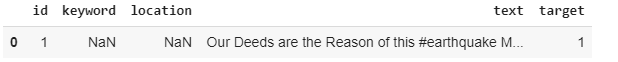

### 2.2 Mapping the real-world problem to a Machine Learning Problem
### 2.2.1 Type of Machine Learning Problem
This is binary classification Problem

### 2.2.2 Performance metric
Submissions are evaluated using F1 between the predicted and expected answers.

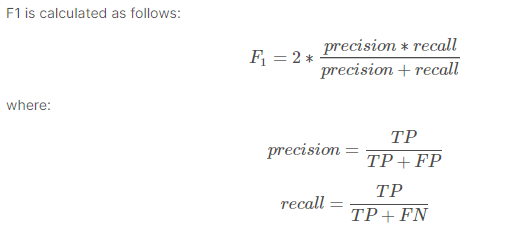

True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!

False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.

False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

# 3. Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import string 
from sklearn import preprocessing
import re
from scipy.sparse import hstack
import emoji
from tqdm.notebook import tqdm
tqdm.pandas()
from textblob import TextBlob, Word, Blobber
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 3.1 Data Loading

In [ ]:
train=pd.read_csv('/content/drive/My Drive/Real or Not?/train.csv')
test=pd.read_csv('/content/drive/My Drive/Real or Not?/test.csv')

In [ ]:
print("Number of data points in train data : ",train.shape[0]) 
print("Number of data points in test data : ",test.shape[0]) 

Number of data points in train data :  7613
Number of data points in test data :  3263


In [ ]:
print("\nNumber of columns in data : ",train.columns) 


Number of columns in data :  Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


In [ ]:
print("Sample train datapoint :") 
train.head(5)

Sample train datapoint :


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
print("Sample test datapoint :") 
test.head(5)

Sample test datapoint :


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Data Analysis

Number of non disaster tweets  : 4342 ( 57.03402075397347 % )
Number Of disaster tweets : 3271 ( 42.96597924602653 % )



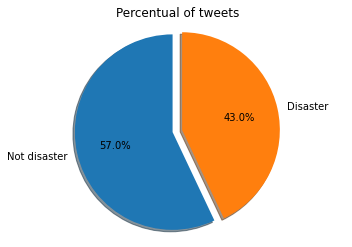

In [ ]:
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
x = train.target.value_counts()
proportion = x/train.shape[0]

print("Number of non disaster tweets  :", x[0],"(",((x[0]/len(train))*100),"% )")
print("Number Of disaster tweets :",x[1], "(",((x[1]/len(train))*100),"% )\n")
 
fig1, ax1 = plt.subplots()
ax1.pie(proportion, 
        explode = (0, 0.1), # only "explode" the 2nd slice
        labels  = ['Not disaster', 'Disaster'], 
        autopct = '%1.1f%%',
        shadow = True, 
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentual of tweets")
plt.show()

**Observation** :

1)In train data ,there are 47%  disaster tweets and 57% are non disaster tweets.

2) Clearly,disaster tweets are less than non disaster tweets.

# Let's Visualise which values are missing the most

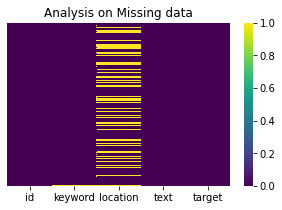

In [ ]:
#train data
plt.figure(figsize=(5,3))
plt.title("Analysis on Missing data")
sns.heatmap(train.isnull(),yticklabels=False ,cbar=True ,cmap='viridis')

In [ ]:
train.isna().mean().round(4) * 100

id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64

**Observation** :In train data , We can see that keyword and location columns have most missing value.

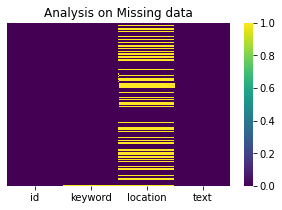

In [ ]:
#test data
plt.figure(figsize=(5,3))
plt.title("Analysis on Missing data")
sns.heatmap(test.isnull(),yticklabels=False ,cbar=True ,cmap='viridis')

In [ ]:
test.isna().mean().round(4) * 100

id           0.00
keyword      0.80
location    33.86
text         0.00
dtype: float64

**Observation** :In test data , We can see that keyword and location columns have most missing value.

# Exploring the 'keyword' column


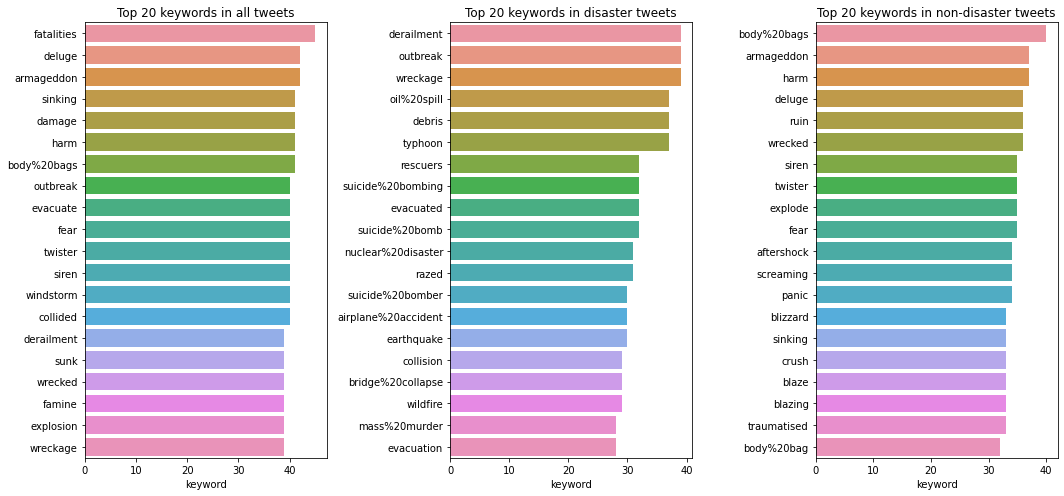

In [ ]:
plt.figure(figsize=(15,7))
plt.tight_layout()
plt.subplot(1,3,1)
plt.tight_layout()
plt.title("Top 20 keywords in all tweets")
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h')

plt.subplot(1,3,2)
plt.tight_layout()
plt.title("Top 20 keywords in disaster tweets")
sns.barplot(y=train['keyword'][train['target']==1].value_counts()[:20].index,x=train['keyword'][train['target']==1].value_counts()[:20],
            orient='h')

plt.subplot(1,3,3)
plt.tight_layout()
plt.title("Top 20 keywords in non-disaster tweets")
sns.barplot(y=train['keyword'][train['target']==0].value_counts()[:20].index,x=train['keyword'][train['target']==0].value_counts()[:20],
            orient='h')

**Observation**

1) In whole training data 'fatalities' keyword is highly seen.

2) In disaster tweets,outbreak, wreckage,derailment these are most repeated keywords.

3) In non-disaster tweets,body%20bags is the most repeated keyword.

4)Now If we observe, in some keywords the string '%20' is included so while cleaning we remove this noisy substring.

5)In disaster tweets, missing value will be filled by 'derailment' keyword.

6)In non-disaster tweets, missing value will be filled by 'body_bags' keyword.



In [ ]:
non_disaster_df= train[train['target']==0]
disaster_df= train[train['target']==1]

non_disaster_df['keyword'].fillna('body_bags',inplace = True)
disaster_df['keyword'].fillna('derailment',inplace = True)

train_df=pd.concat([non_disaster_df,disaster_df])
test['keyword'].fillna('body_bags',inplace = True)

In [ ]:
def fun(text):
  text=re.sub(r'%20', '_', text)
  return text

# remove noisy sub-string from keywords
train_df["clean_keywords"] = train_df["keyword"].progress_apply(lambda text: fun(text))
test["clean_keywords"] = test["keyword"].progress_apply(lambda text: fun(text))

In [ ]:
train.drop(['keyword'], axis=1, inplace=True)
test.drop(['keyword'], axis=1, inplace=True)

# Exploring the 'location' column



In [ ]:
train=train_df

In [ ]:
train.location.value_counts()

USA                      104
New York                  71
United States             50
London                    45
Canada                    29
                        ... 
sÌ£o luis                  1
Temporary Towers           1
East Atlanta, Georgia      1
Greg's place               1
Giddy, Greenland           1
Name: location, Length: 3341, dtype: int64

Since some of the locations are repeated, this will require some bit of cleaning.

In [ ]:
# Replacing the ambigious locations name with Standard names
for i in [train,test]:
  i['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India",
                            "304":"US"},inplace=True)

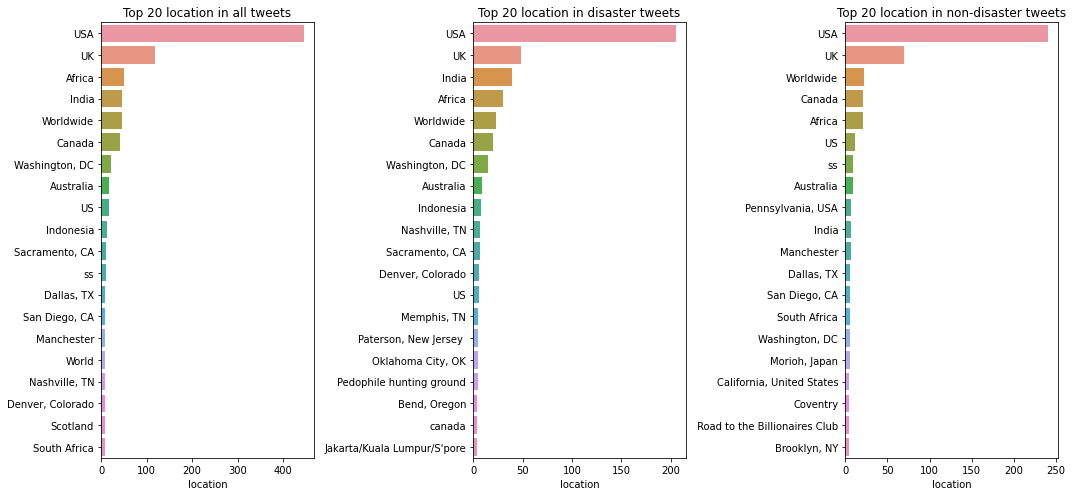

In [ ]:
plt.figure(figsize=(15,7))
plt.tight_layout()
plt.subplot(1,3,1)
plt.tight_layout()
plt.title("Top 20 locations in all tweets")
sns.barplot(y=train['location'].value_counts()[:20].index,x=train['location'].value_counts()[:20],
            orient='h')

plt.subplot(1,3,2)
plt.tight_layout()
plt.title("Top 20 locations in disaster tweets")
sns.barplot(y=train['location'][train['target']==1].value_counts()[:20].index,x=train['location'][train['target']==1].value_counts()[:20],
            orient='h')

plt.subplot(1,3,3)
plt.tight_layout()
plt.title("Top 20 locations in non-disaster tweets")
sns.barplot(y=train['location'][train['target']==0].value_counts()[:20].index,x=train['location'][train['target']==0].value_counts()[:20],
            orient='h')

**Observation**: 

1) In whole training data, Highly repeated locations are USA and UK where USA is repeated more than 400 times and UK is repeated more than 100 times in train dataset.


2) In disaster and non-disaster tweets,USA is repeated more than 200 times.

3)In disaster and non-disaster tweets, missing values will be filled by 'USA' location.



In [ ]:
train['location'].fillna('USA',inplace = True)
test['location'].fillna('USA',inplace = True)

In [ ]:
def loc_fun(lst):
  loc_list = []
  for i in lst:
    temp = ""
    
    i=re.sub(r'/', ' ', i)
    i=re.sub(r'http\S+', ' ', i)
    i=i.replace('hkXfYMhEx',' ') 
    i = re.sub('[^A-Za-z]+', ' ', i)
    i=i.replace('ÌÏT: 35.223347,-80.827834',' ') 
    i=i.replace('i got 1/13 menpa replies, omg',' ')
    i = re.sub("\S*\d\S*", " ", i).strip()
    

    for j in i.split(','):
      if len(j.split())>1:
        temp+=j.strip()+" "
      else:
        temp+=j.strip()+" " 

      
    temp = (temp.strip()).replace(' ','_') 
    if len(temp)<2:
      temp='USA'
    loc_list.append(temp)
  return loc_list
    
loc_arr=train['location'].values
train['clean_locations']= loc_fun(loc_arr)
loc_arr=test['location'].values
test['clean_locations']= loc_fun(loc_arr)


In [ ]:
train.drop(['location'], axis=1, inplace=True)
test.drop(['location'], axis=1, inplace=True)

# Exploring the 'text' column

In [ ]:
#https://www.kaggle.com/ekhtiar/unintended-eda-with-tutorial-notes

def generate_word_cloud(identity, disaster_tweets, non_disaster_tweets):
  '''this simple function is used  to generate the wordcloud per identity group'''
  # convert stop words to sets as required by the wordcloud library
  stop_words = set(stopwords.words("english"))
  # create toxic wordcloud
  wordcloud_toxic = WordCloud(max_font_size=100, max_words=100, background_color="black", stopwords=stop_words).generate(str(disaster_tweets))
  # create non-toxic wordcloud
  wordcloud_non_toxic = WordCloud(max_font_size=100, max_words=100, background_color="black", stopwords=stop_words).generate(str(non_disaster_tweets))
  # draw the two wordclouds side by side using subplot
  fig = plt.figure(figsize=[15,5])
  fig.add_subplot(1, 2, 1).set_title("disaster_tweets Wordcloud", fontsize=26)
  plt.imshow(wordcloud_toxic, interpolation="bilinear")
  plt.axis("off")

  fig.add_subplot(1, 2, 2).set_title("non_disaster_tweets Wordcloud", fontsize=26)
  plt.imshow(wordcloud_non_toxic, interpolation="bilinear")
  plt.axis("off")
  
  plt.subplots_adjust(top=0.85)
  plt.suptitle('Word Cloud - {} Feature'.format(identity), size = 26)
  plt.show()

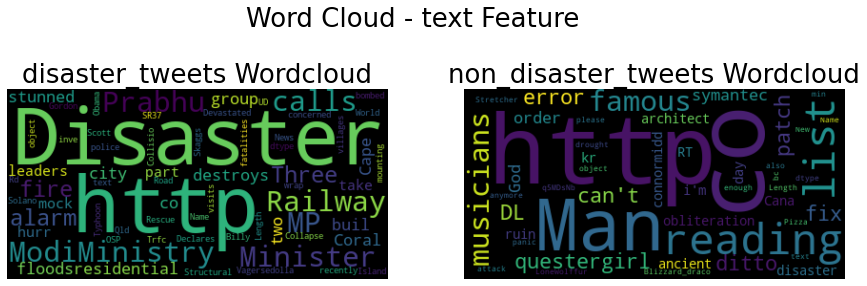

In [ ]:
generate_word_cloud('text', train.loc[train['target'] ==1]['text'].sample(3000), train.loc[train['target'] ==0]['text'].sample(4000))

**Observations**:
- **In disaster text,more frequent words are Disaster,http,Railway.**
- **In non_disaster text,more frequent words are http,Man,reading,list.**

# Text Preprocessing
- Convert to lower case
- Clean contractions
- Clean special charactor
- Convert small caps

In [ ]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": 
    "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
    "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
    "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
    "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
    "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
    "Trump's": "trump is", "Obama's": "obama is", "Canada's": "canada is", "today's": "today is"
}

In [ ]:
#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
stop_words = set(stopwords.words('english')) 

def clean_text(text):
  '''this for preprocessing text feature'''
  text=re.sub(r'http\S+', 'link', text)
  text = ' '.join(contraction_mapping[word] if word in contraction_mapping else word for word in text.split(" "))
  #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
  text = re.sub("\S*\d\S*", "", text).strip()
  text=emoji.demojize(text, delimiters=(" ", ""))
  text = re.sub('[^A-Za-z]+', ' ', text)
  text = ' '.join(e for e in text.split() if e not in stop_words)  
  if len(text)<2:
    text='unknown'
  return text.lower().strip()

In [ ]:
train["clean_text"] = train["text"].progress_apply(lambda text: clean_text(text))
test["clean_text"] = test["text"].progress_apply(lambda text: clean_text(text))

In [ ]:
train.drop(['text'], axis=1, inplace=True)
test.drop(['text'], axis=1, inplace=True)

# Feature Engineering

In [ ]:
#is to add word count of comment data 
train['comment_word_count'] = train.clean_text.apply(lambda x: len(x.split()))
test['comment_word_count'] = test.clean_text.apply(lambda x: len(x.split()))

#is to add word count of comment data 
train['comment_char_count'] = train.clean_text.apply(lambda x: len(x))
test['comment_char_count'] = test.clean_text.apply(lambda x: len(x))

# Count number of positive and negative words in each comment
- https://gist.github.com/mkulakowski2/4289441
- https://gist.github.com/mkulakowski2/4289437

In [ ]:
#I have created 2 files one for  positive words taken from https://gist.github.com/mkulakowski2/4289437 ,another for negative words taken from https://gist.github.com/mkulakowski2/4289441

#load pos,neg words
pos_path='/content/drive/My Drive/Real or Not?/pos.txt'
neg_path='/content/drive/My Drive/Real or Not?/neg.txt'

def load_file(path):
  fp=open(path,'r')
  all_lines=fp.readlines()
  words_list=[]
  for line in all_lines:
    words_list.append(line.strip())
  fp.close()
  return words_list

pos_words=load_file(pos_path)
neg_words=load_file(neg_path)

#count  number of positive and negative words in each tweet
def pos_word_count(comment):
  count=0
  for word in comment.split():
    if word in pos_words:
      count=count+1
  return count  

def neg_word_count(comment):
  count=0
  for word in comment.split():
    if word in neg_words:
      count=count+1
  return count  

In [ ]:
# pos_word_count 
count=[]
for i in train['clean_text'].values:
  count.append(pos_word_count(str(i)))
train['pos_word_count']=count

count=[]
for i in train['clean_text'].values:
  count.append(neg_word_count(str(i)))
train['neg_word_count']=count


count=[]
for i in test['clean_text'].values:
  count.append(pos_word_count(str(i)))
test['pos_word_count']=count

count=[]
for i in test['clean_text'].values:
  count.append(neg_word_count(str(i)))
test['neg_word_count']=count

# Find the sentiment of each comment

In [ ]:
#https://www.pluralsight.com/guides/natural-language-processing-extracting-sentiment-from-text-data
%%time
sentiment_count=[]
for i in train['clean_text'].values:
  sentiment_count.append(TextBlob(i).sentiment[0])
train['sentiment']=sentiment_count

sentiment_count=[]
for i in test['clean_text'].values:
  sentiment_count.append(TextBlob(i).sentiment[0])
test['sentiment']=sentiment_count

CPU times: user 5.25 s, sys: 0 ns, total: 5.25 s
Wall time: 5.25 s


# Univariate Analysis: comment_word_count feature

Text(8.758127170138891, 0.5, 'Ratio')

<Figure size 936x576 with 0 Axes>

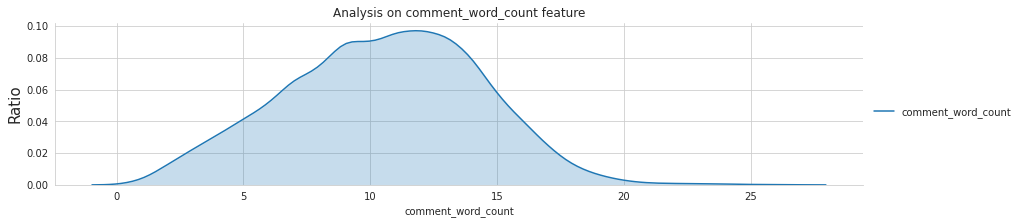

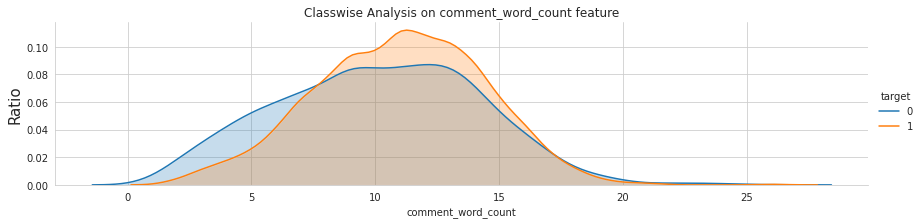

In [ ]:
plt.figure(figsize=(13,8))

sns.FacetGrid(train,aspect=4).map(sns.kdeplot,'comment_word_count',shade= True).add_legend() 
plt.title("Analysis on comment_word_count feature")
plt.ylabel('Ratio',fontsize=15) 

sns.FacetGrid(train, hue="target",aspect=4).map(sns.kdeplot,'comment_word_count',shade= True).add_legend()
plt.title("Classwise Analysis on comment_word_count feature") 
plt.ylabel('Ratio',fontsize=15) 

**Observation :** 

1)Many tweets are with word count of 8-13.

2) Distribution of disaster tweets is peaked than distribution of non-disaster tweets.

3)Distribution of both classes is overlapping.
 

# Univariate Analysis: comment_char_count feature

Text(9.383452690972227, 0.5, 'Ratio')

<Figure size 936x576 with 0 Axes>

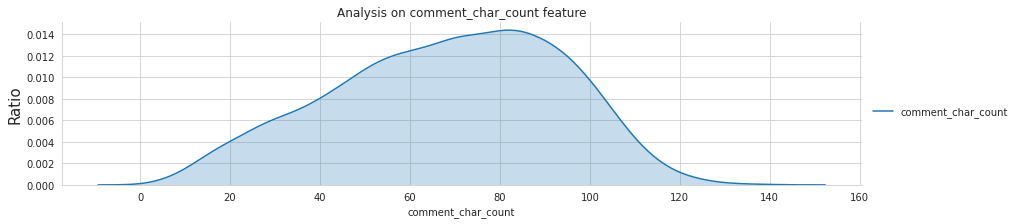

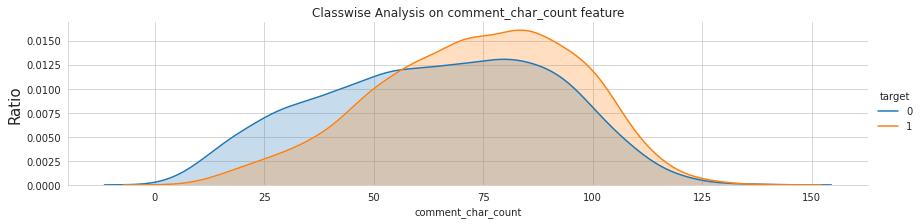

In [ ]:
plt.figure(figsize=(13,8))

sns.FacetGrid(train,aspect=4).map(sns.kdeplot,'comment_char_count',shade= True).add_legend() 
plt.title("Analysis on comment_char_count feature")
plt.ylabel('Ratio',fontsize=15) 

sns.FacetGrid(train, hue="target",aspect=4).map(sns.kdeplot,'comment_char_count',shade= True).add_legend()
plt.title("Classwise Analysis on comment_char_count feature") 
plt.ylabel('Ratio',fontsize=15) 

**Observation :** 

1)Many tweets are with char count of 75-85.

2) Distribution of disaster tweets is peaked than distribution of non-disaster tweets.

3)Distribution of both classes is overlapping.
 

# Violin plot

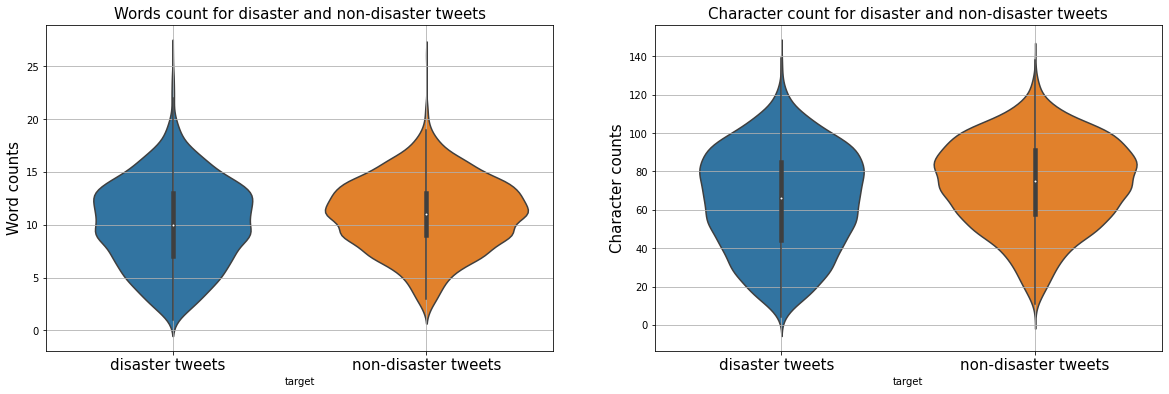

In [ ]:
#getting violin plot on train data with comment_word_countfeature

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.violinplot(x = 'target', y = 'comment_word_count', data = train[0:])
plt.xticks([0,1],('disaster tweets  ','non-disaster tweets'), fontsize=15) 
plt.ylabel('Word counts', fontsize=15) 
plt.title('Words count for disaster and non-disaster tweets', fontsize=15) 
plt.grid() 

plt.subplot(1,2,2)
sns.violinplot(x = 'target', y = 'comment_char_count', data = train[0:])
plt.xticks([0,1],('disaster tweets  ','non-disaster tweets'), fontsize=15) 
plt.ylabel('Character counts',fontsize=15) 
plt.title('Character count for disaster and non-disaster tweets', fontsize=15) 
plt.grid() 

**Observation**
- This plot giving more clear picture than distribution plot.
For Disaster tweets word count distribution is flattened at count 9-13 and In character count distribution is flattened at count 75-90.

- For non-disaster tweets word count distribution is peaked at count 12 and In character count distribution is flattened at count 85.

- Average word count of disaster tweets is 10 and for non-disaster tweets its 12.

- Average char count of disaster tweets is 65 and for non-disaster tweets its 75.
- Distributions of disaster and non-disaster tweets are almost same.

# Univariate Analysis: positive and negative words count of each comment

In [ ]:
cat_cols = ['pos_word_count','neg_word_count']

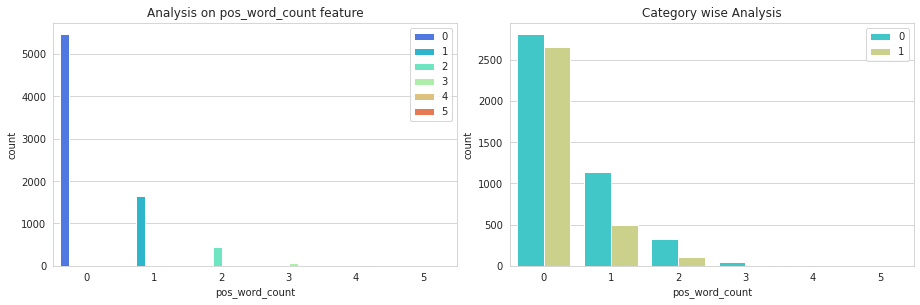

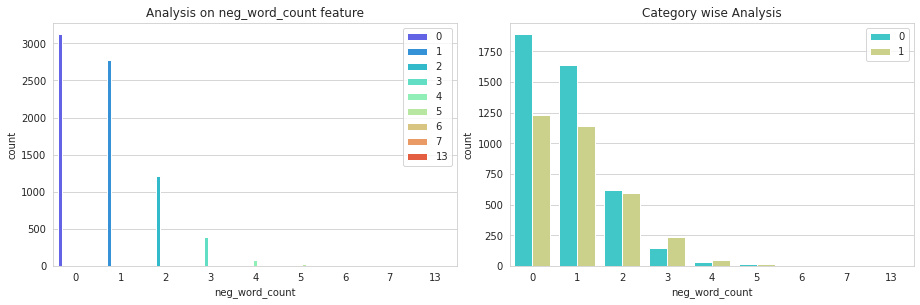

In [ ]:
for col in cat_cols:
  plt.figure(figsize=(13,8))
  plt.tight_layout(h_pad=2,w_pad=3)
  plt.subplot(2,2,1)
  plt.tight_layout(h_pad=2,w_pad=3)
  sns.set_style('whitegrid')
  plt.title("Analysis on {0} feature".format(col))
  sns.countplot(x=col,hue=col,data=train,palette='rainbow')
  plt.legend(loc=1)

  plt.subplot(2,2,2)
  plt.tight_layout(h_pad=2,w_pad=3)
  sns.set_style('whitegrid')
  plt.title("Category wise Analysis".format(col))
  sns.countplot(x=col,hue='target',data=train,palette='rainbow')
  plt.legend(loc=1)

**Observation**: 

- pos_word_count Feature: 

 - 1)Here tweets with 0 positive words are more and some tweets included with 1 or 2 positive words.

 
- neg_word_count Feature: 

 - 1)Here tweets with 0 or 1 negative words are more and some tweets included with 2-4 negative words.


Text(8.77038845486112, 0.5, 'Ratio')

<Figure size 936x576 with 0 Axes>

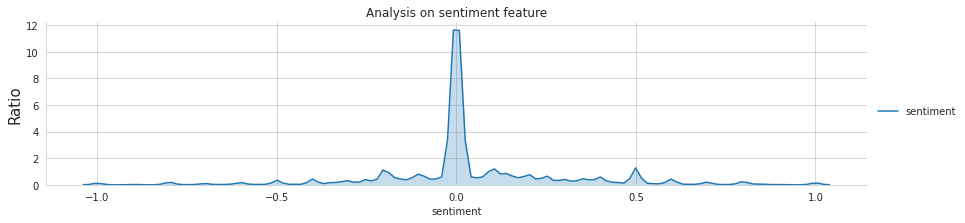

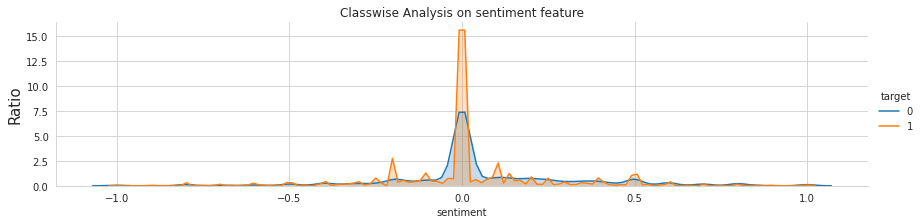

In [ ]:
plt.figure(figsize=(13,8))

sns.FacetGrid(train,aspect=4).map(sns.kdeplot,'sentiment',shade= True).add_legend() 
plt.title("Analysis on sentiment feature")
plt.ylabel('Ratio',fontsize=15) 

sns.FacetGrid(train, hue="target",aspect=4).map(sns.kdeplot,'sentiment',shade= True).add_legend()
plt.title("Classwise Analysis on sentiment feature") 
plt.ylabel('Ratio',fontsize=15) 

**Observation**: 

1) More than 90% data is neutral.

2) Most of the neutral tweets are from disaster category.

3)Neutrality ratio of non-disaster tweets are half of the disaster tweets.

# Encoding categorical feature : clean_keywords

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(train['clean_keywords'].values) 

# we use the fitted CountVectorizer to convert the text to vector
train_clean_keywords = vectorizer.transform(train['clean_keywords'].values)
test_clean_keywords = vectorizer.transform(test['clean_keywords'].values)

print("After vectorizations")
print(train_clean_keywords.shape)
print(test_clean_keywords.shape)
print("="*100)

After vectorizations
(7613, 221)
(3263, 221)


# Encoding categorical feature : clean_locations

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(train['clean_locations'].values) 

# we use the fitted CountVectorizer to convert the text to vector
train_clean_locations = vectorizer.transform(train['clean_locations'].values)
test_clean_locations = vectorizer.transform(test['clean_locations'].values)

print("After vectorizations")
print(train_clean_locations.shape)
print(test_clean_locations.shape)
print("="*100)

After vectorizations
(7613, 2944)
(3263, 2944)


# BOW of feature :clean_text

In [ ]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=25000)
vectorizer.fit(train['clean_text'].values) 

# we use the fitted CountVectorizer to convert the text to vector
train_clean_text = vectorizer.transform(train['clean_text'].values)
test_clean_text = vectorizer.transform(test['clean_text'].values)

print("After vectorizations")
print(train_clean_text.shape)
print(test_clean_text.shape)
print("="*100)

After vectorizations
(7613, 2359)
(3263, 2359)


In [ ]:
numerical_train_1=train['comment_word_count'].values.reshape(-1, 1)
numerical_train_2=train['comment_char_count'].values.reshape(-1, 1)
numerical_train_3=train['pos_word_count'].values.reshape(-1, 1)
numerical_train_4=train['neg_word_count'].values.reshape(-1, 1)
numerical_train_5=train['sentiment'].values.reshape(-1, 1)

numerical_test_1=test['comment_word_count'].values.reshape(-1, 1)
numerical_test_2=test['comment_char_count'].values.reshape(-1, 1)
numerical_test_3=test['pos_word_count'].values.reshape(-1, 1)
numerical_test_4=test['neg_word_count'].values.reshape(-1, 1)
numerical_test_5=test['sentiment'].values.reshape(-1, 1)

num_tr=np.concatenate((numerical_train_1,numerical_train_2,numerical_train_3,numerical_train_4,numerical_train_5),axis=1)
num_test=np.concatenate((numerical_test_1,numerical_test_2,numerical_test_3,numerical_test_4,numerical_test_5),axis=1)

numerical=StandardScaler()
numerical_train=numerical.fit_transform(num_tr)
numerical_test=numerical.transform(num_test)

In [ ]:
from scipy.sparse import hstack
X_tr = hstack((train_clean_keywords,train_clean_locations,train_clean_text,numerical_train)).tocsr()
X_te = hstack((test_clean_keywords,test_clean_locations,test_clean_text,numerical_test)).tocsr()

In [ ]:
X_tr.shape

(7613, 5529)

In [ ]:
X_te.shape

(3263, 5529)